# ELE510 Image Processing with robot vision: LAB, Exercise 6, Image features detection.

### Daniel Fylling

## Abstract

This exercise investigates two image feature detection techniques: the Canny edge detector and the Harris corner detector. 
1. A home-made version of the Canny algorithm is made, which includes gradient computation, non-maximum suppression, and thresholding. The rersult is compared to the cv2.Canny function, and we see similar results. The cv2 version is clearly more polished.
2. The Harris corner detector is explored using OpenCV. The cv2.cornerHarris function is applied to detect corners and compare the results with different 'k' values, demonstrating the impact of parameter adjustments.

## Problem 1

**Intensity edges** are pixels in the image where the intensity (or graylevel) function changes rapidly.

The **Canny edge detector** is a classic algorithm for detecting intensity edges in a grayscale image that relies on the gradient magnitude. The algorithm was developed by John F. Canny in 1986. It is a multi-stage algorithm that provides good and reliable detection.

**a)** Create the **Canny algorithm**, described at pag. 336 (alg. 7.1). For the last step (`EDGELINKING`) you can either use the algorithm 7.3 at page 338 or the `HYSTERESIS THRESHOLD` algorithm 10.3 described at page 451.
All the following images are taken from the text book [1].

![canny.png](images/canny.png)

![nonmaxsuppression.png](images/nonmaxsuppression.png)

![edgelinking.png](images/edgelinking.png)

**Remember:**

- Sigma (second parameter in the Canny algorithm) is not necessary for the calculation since the Sobel operator (in opencv) combines the Gaussian smoothing and differentiation, so the results is nore or less resistant to the noise. 
- We are defining the low and high thresholds manually in order to have a better comparison with the predefined opencv function. It is possible to extract the low and high thresholds automatically from the image but it is not required in this problem.

**b)** Test your algorithm with a image of your choice and compare your results with the predefined function in opencv: 

```python
cv2.Canny(img, t_low, t_high, L2gradient=True)
``` 
[Documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=canny#canny).

### P.S. : 
<div class="alert alert-block alert-info">
The goal of this problem it is not to create a **perfect** replication of the algorithm in opencv, but to understand the various steps involved and to be able to extract the edges from an ima ge using these steps.
</div>

In [66]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  
import warnings
warnings.filterwarnings('ignore')

In [67]:

def computeImageGradient(Im):
    # Sobel operator  to find the first derivate in the horizontal and vertical directions
    
    ## TO DO: The default ksize is 3, try different values and comment the result 
    g_x = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=1, dy=0, ksize = 3)
    g_y = cv2.Sobel(Im, ddepth=cv2.CV_32F, dx=0, dy=1, ksize = 3)
    
    ############################
    # Calculate the magnitude and the gradient direction like it is performed during the 
    # assignment 4 (problem 2a)
    G_mag = np.sqrt(np.square(g_x)+np.square(g_y))
    G_phase = np.arctan2(g_y, g_x)
        
    return G_mag, G_phase

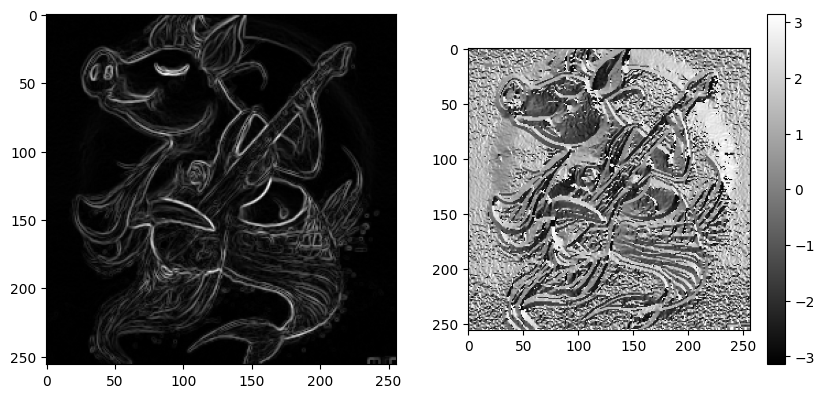

In [68]:
Im = cv2.imread('./images/DALLE-mermaidpig.png', cv2.IMREAD_GRAYSCALE)

G_mag, G_phase = computeImageGradient(Im)

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(G_mag, cmap='gray')
plt.subplot(222)
plt.imshow(G_phase, cmap='gray')
plt.colorbar()
plt.show()

In [69]:
# NonMaxSuppression algorithm 
def nonMaxSuppression(G_mag, G_phase):
    G_localmax = np.zeros((G_mag.shape))
    X, Y = G_mag.shape

    # For each pixel, adjust the phase to ensure that -pi/8 <= theta < 7*pi/8
    for x in range(X-2):
        x=x+1
        for y in range(Y-2):
            y=y+1
            theta = G_phase[x,y]
            if theta >= np.pi*0.875:
                theta = theta - np.pi
            if theta < -np.pi*0.125:
                theta = theta + np.pi
            if -np.pi*0.125 <= theta < np.pi*0.125:
                n1 = G_mag[x-1, y]
                n2 = G_mag[x+1, y]
            if np.pi*0.125 <= theta < np.pi*0.375:
                n1 = G_mag[x-1, y-1]
                n2 = G_mag[x+1, y+1]
            if np.pi*0.375 <= theta < np.pi*0.625:
                n1 = G_mag[x, y-1]
                n2 = G_mag[x, y+1]
            if np.pi*0.625 <= theta < np.pi*0.875:
                n1 = G_mag[x, y-1]
                n2 = G_mag[x, y+1]               
            if (G_mag[x,y] >= n1) & (G_mag[x,y] >= n2):
                G_localmax[x,y] = G_mag[x,y]
    
    return G_localmax

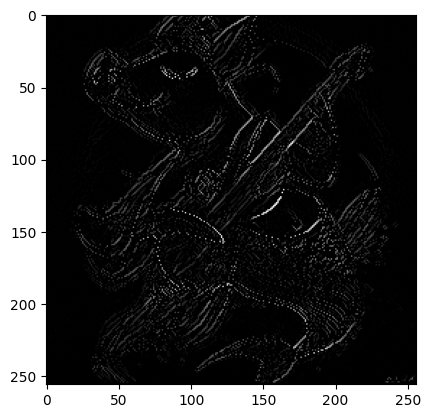

In [70]:
G_localmax = nonMaxSuppression(G_mag, G_phase)


plt.imshow(G_localmax, cmap='gray')
plt.show()

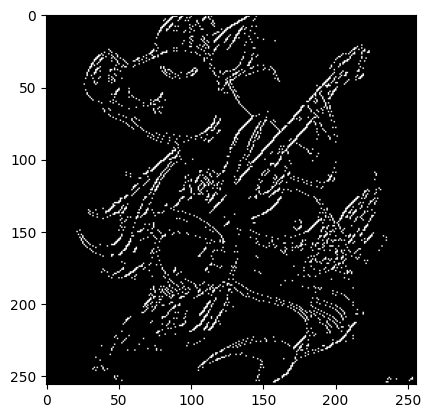

In [71]:
alpha = 0.2
beta = 0.2

edges_all = G_localmax[G_localmax != 0]
t_high = np.percentile(edges_all, 100*(1-alpha))
t_low = t_high*beta

I_edges = np.zeros((G_localmax.shape))
I_edges[G_localmax > t_high] = True

plt.imshow(I_edges, cmap='gray')
plt.show()

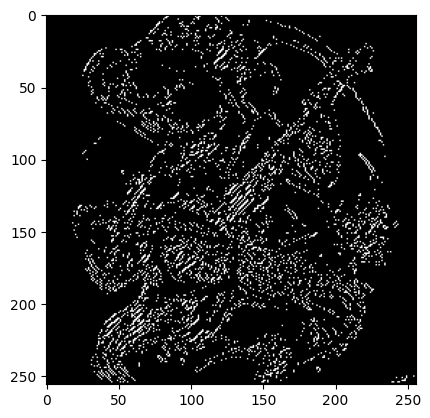

In [72]:
frontier = np.array(np.where(G_localmax > t_high)).T
weak_edges = np.zeros((G_localmax.shape))
weak_edges[np.logical_and(t_low < G_localmax, G_localmax <= t_high)] = True

plt.imshow(weak_edges, cmap='gray')
plt.show()

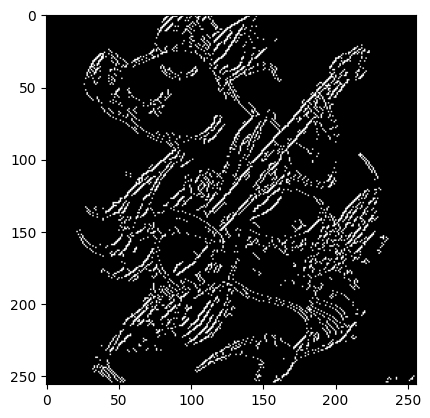

In [73]:
while frontier.size > 0:
    p = frontier[0]
    frontier = frontier[1:]
    for x in [p[0]-1,p[0],p[0]+1]:
        for y in [p[1]-1,p[1],p[1]+1]:
            if weak_edges[x,y] == True:
                weak_edges[x,y] = False
                frontier = np.r_[frontier, [[x,y]]]
                I_edges[x,y] = True

plt.imshow(I_edges, cmap='gray')
plt.show()

In [74]:
def edgeLinking(G_localmax, t_low, t_high):
    I_edges = np.zeros((G_localmax.shape))
    
    # Set the threshold image and perform edge linking (or hysteresis thresholding)
    I_edges[G_localmax > t_high] = True
    frontier = np.array(np.where(G_localmax > t_high)).T
    
    # Defining weak edges based on threshold values
    weak_edges = np.zeros((G_localmax.shape))
    weak_edges[np.logical_and(t_low < G_localmax, G_localmax <= t_high)] = True
    
    while frontier.size > 0:
        # frontier starts as a list of strong edges
        p = frontier[0]
        frontier = frontier[1:]
        # each point is investigated once to see if it has weak edge neighbors
        for x in [p[0]-1,p[0],p[0]+1]:
            for y in [p[1]-1,p[1],p[1]+1]:
                if weak_edges[x,y] == True:
                    # weak edge "upgraded" to strong
                    frontier = np.r_[frontier, [[x,y]]]
                    # ..and added to output image
                    I_edges[x,y] = True
                    # weak edge removed from weak register
                    weak_edges[x,y] = False
    return I_edges

In [75]:
"""
Function that performs the Canny algorithm.

The entire cell is locked, thus you can only test the function and NOT change it!

Input: 
    - Im: image in grayscale
    - t_low: first threshold for the hysteresis procedure (edge linking)
    - t_high: second threshold for the hysteresis procedure (edge linking)
"""
def my_cannyAlgorithm(Im, t_low, t_high):
    ## Compute the image gradient 
    G_mag, G_phase = computeImageGradient(Im)
    
    ## NonMaxSuppression algorithm 
    G_localmax = nonMaxSuppression(G_mag, G_phase)
        
    ## Edge linking
    if t_low>t_high: t_low, t_high = t_high, t_low
    I_edges = edgeLinking(G_localmax, t_low, t_high)
    
    plt.figure(figsize=(30,30))
    plt.subplot(141), plt.imshow(G_mag, cmap='gray')
    plt.title('Magnitude image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(142), plt.imshow(G_phase, cmap='gray')
    plt.title('Phase image.'), plt.xticks([]), plt.yticks([])
    plt.subplot(143), plt.imshow(G_localmax, cmap='gray')
    plt.title('After non maximum suppression.'), plt.xticks([]), plt.yticks([])
    plt.subplot(144), plt.imshow(I_edges, cmap='gray')
    plt.title('Threshold image.'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return I_edges

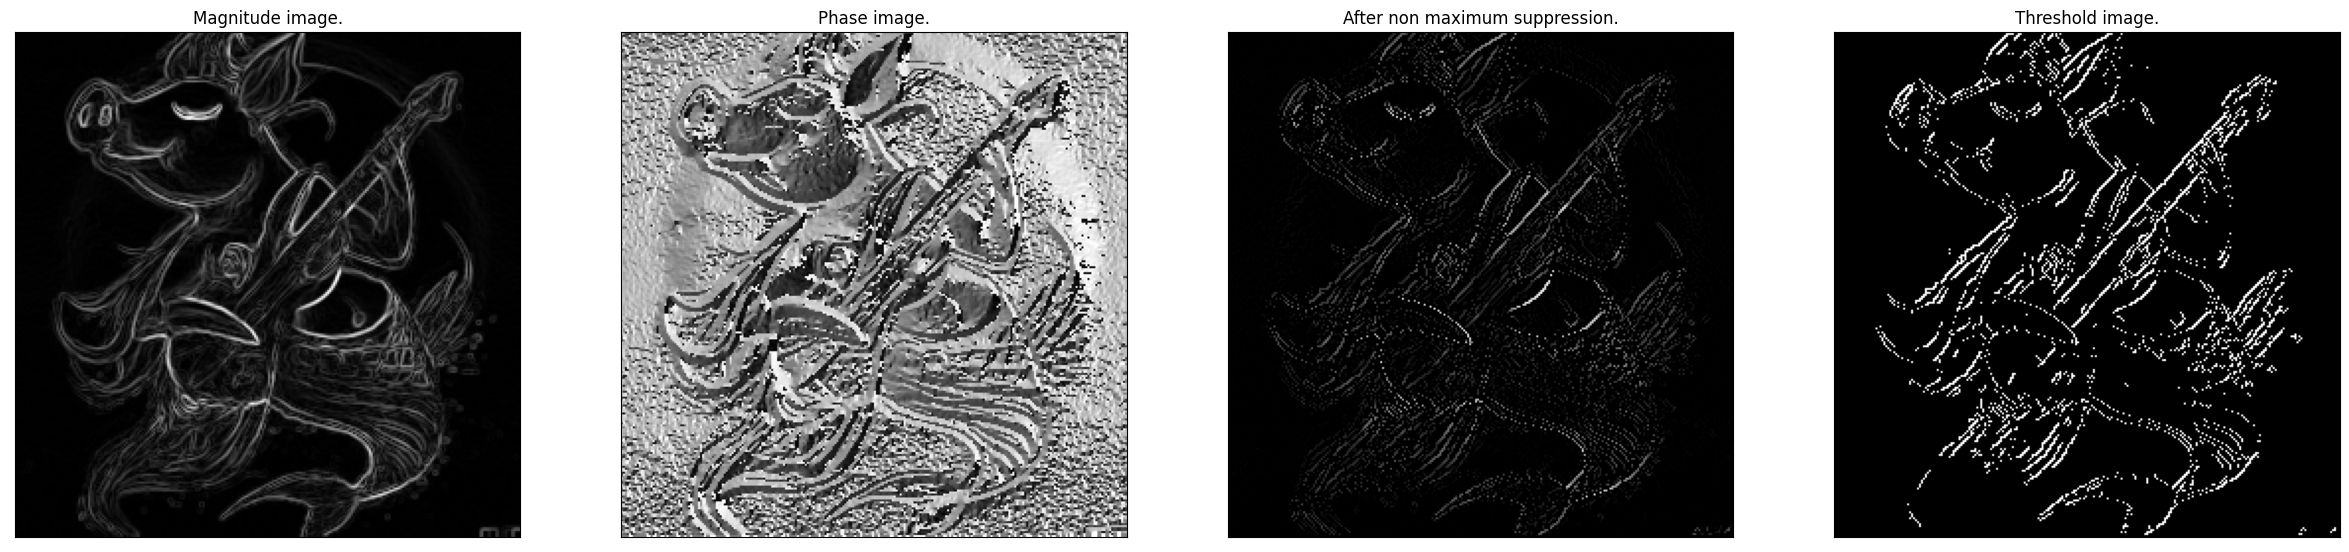

In [76]:

# Im = cv2.imread('cameraman.jpg', cv2.IMREAD_GRAYSCALE)

t_low = 100
t_high = 250
I_edges = my_cannyAlgorithm(Im, t_low, t_high)


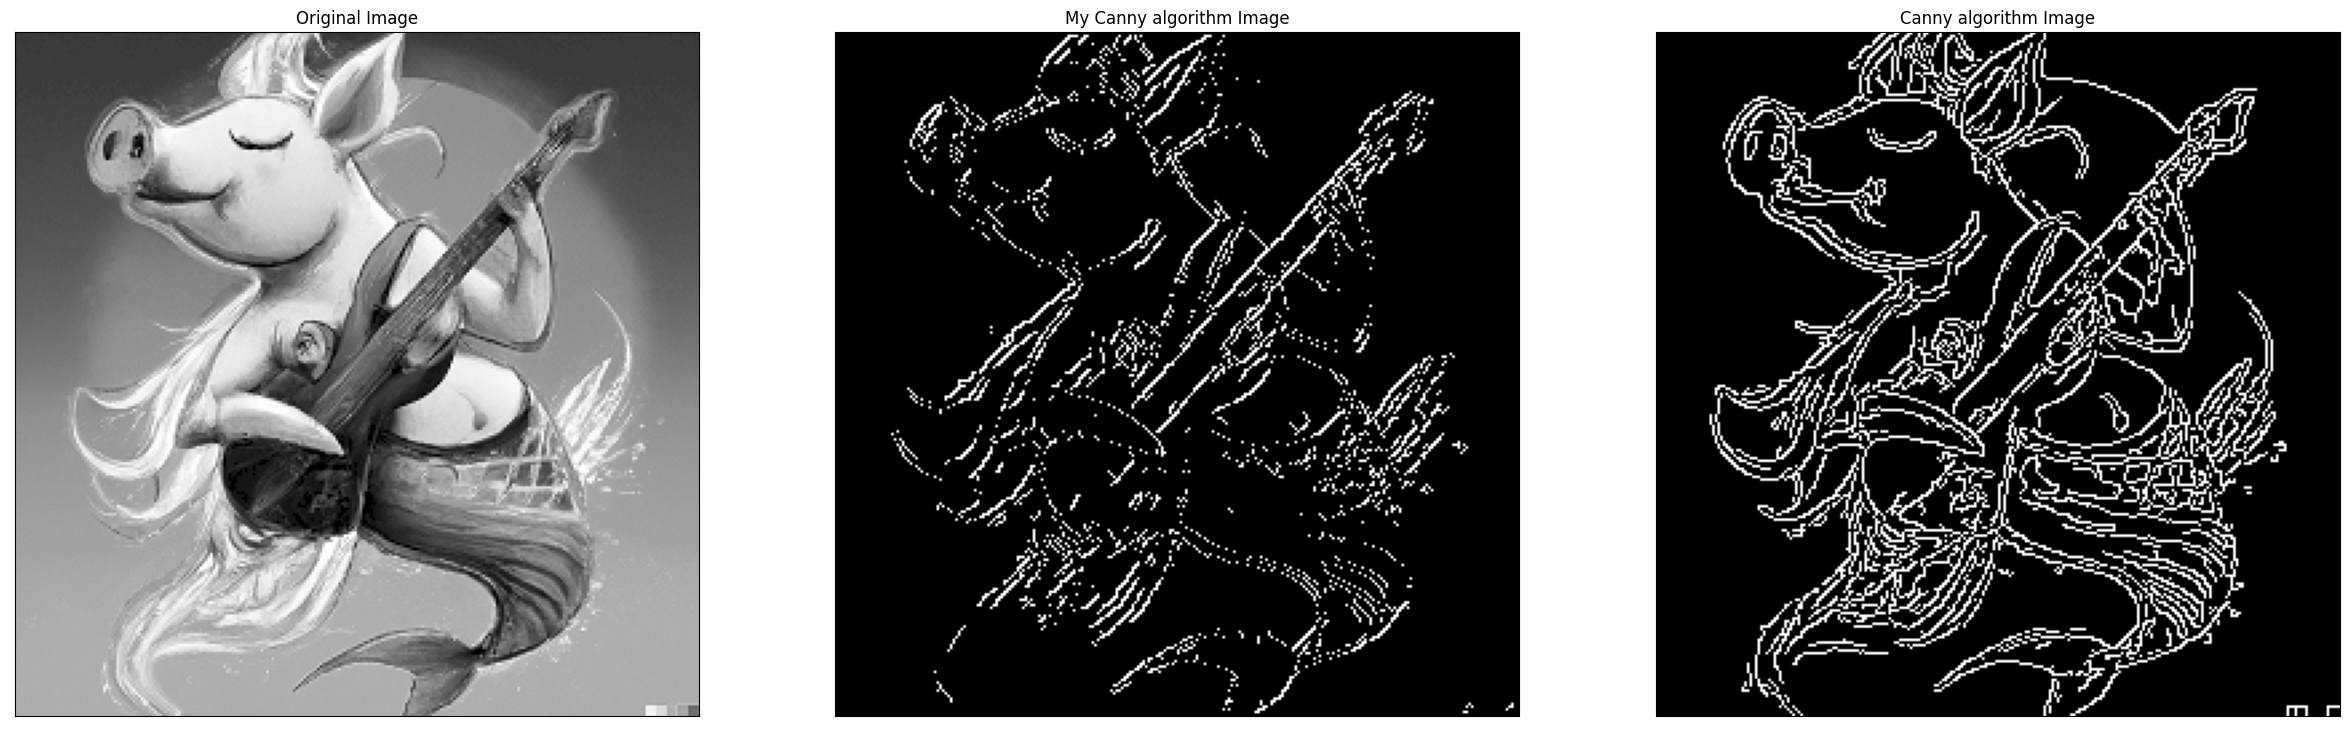

In [77]:
# LOCKED cell: useful to check and visualize the results.

plt.figure(figsize=(30,30))
plt.subplot(131), plt.imshow(Im, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132), plt.imshow(I_edges, cmap='gray')
plt.title('My Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.subplot(133), plt.imshow(cv2.Canny(Im,t_low, t_high, L2gradient=False), cmap='gray')
plt.title('Canny algorithm Image'), plt.xticks([]), plt.yticks([])
plt.show()

# Problem 2

One of the most popular approaches to feature detection is the **Harris corner detector**, after a work of Chris Harris and Mike Stephens from 1988.

**a)** Use the function in opencv `cv2.cornerHarris(...)` ([Documentation](https://docs.opencv.org/master/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)) with `blockSize=3, ksize=3, k=0.04` with the **./images/chessboard.png** image to detect the corners (you can find the image on CANVAS).

**b)** Plot the image with the detected corners found.

**Hint**: Use the function `cv2.drawMarker(...)` ([Documentation](https://docs.opencv.org/4.5.3/d6/d6e/group__imgproc__draw.html#ga644c4a170d4799a56b29f864ce984b7e)) to show the corners in the image.

**c)** Detect the corners using the images **./images/arrow_1.jpg**, **./images/arrow_2.jpg** and **./images/arrow_3.jpg**; describe and compare the results in the three images.

**d)** What happen if you change (increase/decrease) the `k` constant for the "corner points"? 


In [150]:
def corners(Im, subplot = 111, blockSize=3, ksize=3, k=0.04, thresh=0.99):
    corner_detector = cv2.cornerHarris(Im, blockSize=blockSize, ksize=ksize, k=k)

    threshold = thresh*corner_detector.max() 
    corner_locations = np.where(corner_detector > threshold)
    
    plt.subplot(subplot)
    plt.scatter(corner_locations[1],corner_locations[0], 100, 'r', 'x')
    plt.imshow(Im, cmap='gray')
    plt.title("Corner Detection")


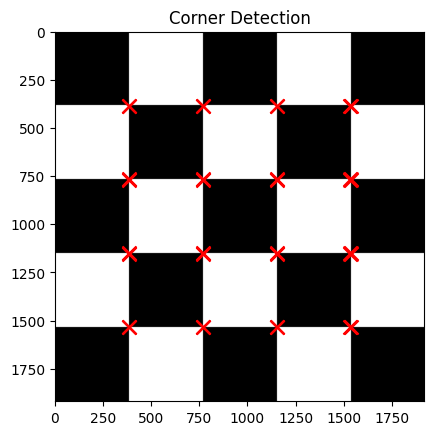

In [151]:
Im = cv2.imread('./images/chessboard.png', cv2.IMREAD_GRAYSCALE)
corners(Im)

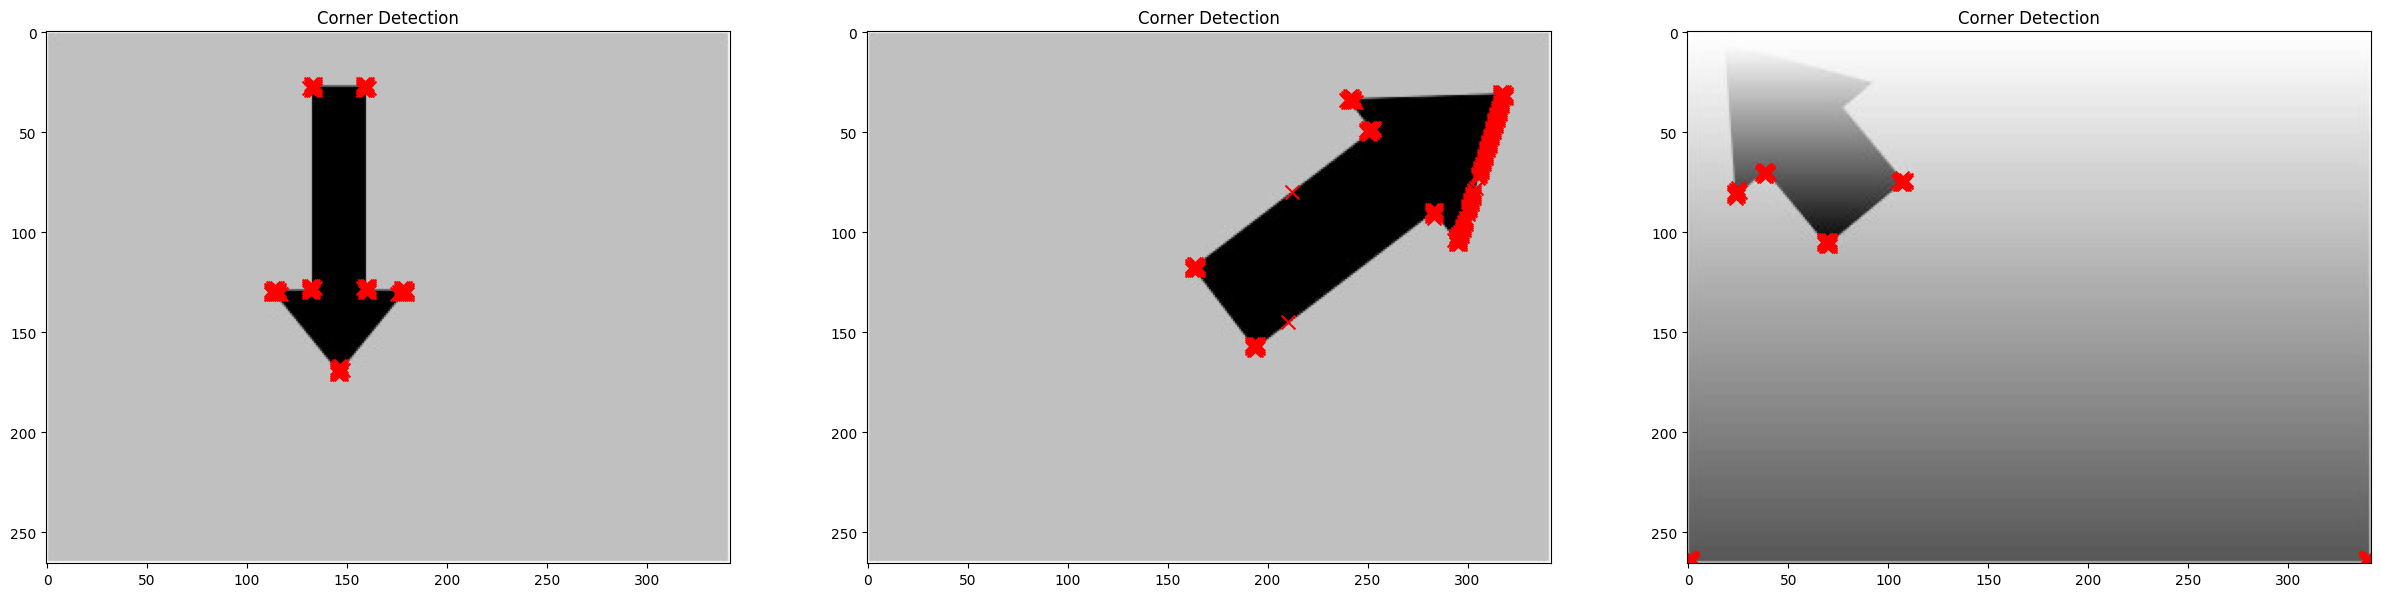

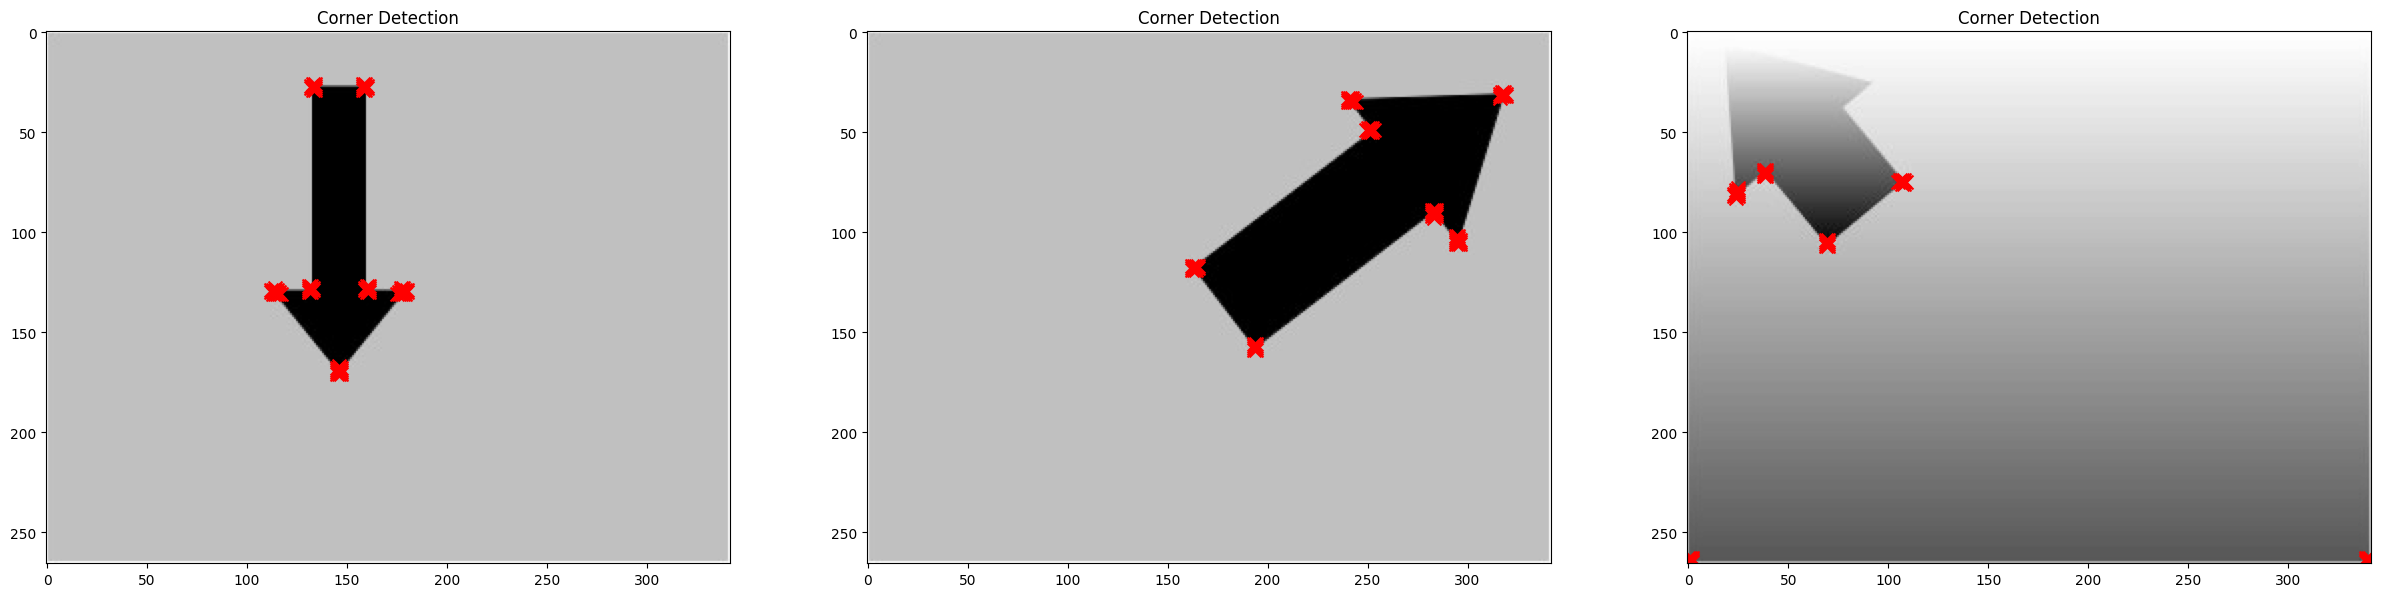

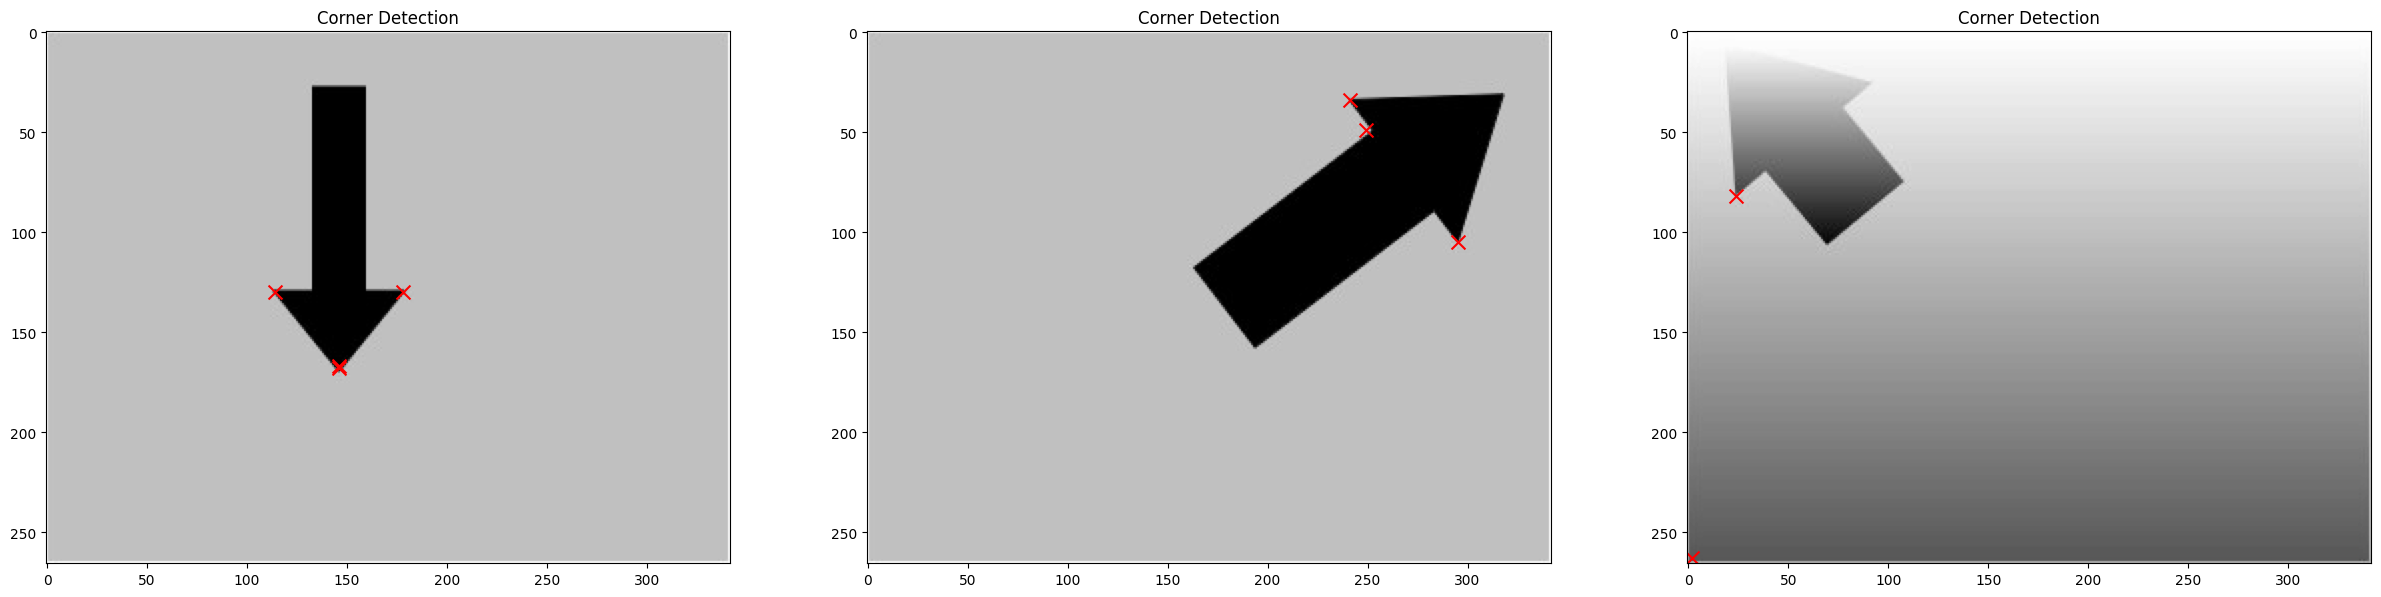

In [155]:
k_all = np.array([0.0001, 0.04, 0.24])

for n, k in enumerate(k_all):
    blockSize=3
    ksize=3
    thresh=0.01

    plt.figure(figsize=(30,30))

    Im = cv2.imread('./images/arrow_1.jpg', cv2.IMREAD_GRAYSCALE)
    corners(Im, 331 + 3*n, blockSize=blockSize, ksize=ksize, k=k, thresh=thresh)

    Im = cv2.imread('./images/arrow_2.jpg', cv2.IMREAD_GRAYSCALE)
    corners(Im, 332 + 3*n, blockSize=blockSize, ksize=ksize, k=k, thresh=thresh)

    Im = cv2.imread('./images/arrow_3.jpg', cv2.IMREAD_GRAYSCALE)
    corners(Im, 333 + 3*n, blockSize=blockSize, ksize=ksize, k=k, thresh=thresh)

**Observations:**

**b)**
1. For an appropriate value of k, and clear interfaces the markers indicate corners very well.
2. In the gradient arrow it seems that the contrast between the faded part of the arrow and the background is too small to be able to define a corner.

**c)**
1. The k-value seems to plays a role as a threshold for which corner points to include in the final presentation. 
2. A thresholding functionality was added to the output of the harris corner function as well, making me think that adding that part may have been redundant.

# Problem 3 

**a)** What is the SIFT approach? Describe the steps involved.

SIFT (Scale Invariant Feature Transform) works similar to the corner detector, where it finds characteristic features in an image. The steps involved are:
1. Compute a Laplacian pyramid.
2. Look for local maxima among 26-neighbors of each pixel for each scale.
3. Discard pixels in untextured by subtracting different levels of smoothing at the same octave / scale.

**b)** Why this approach is more popular than the Harris detector?

Because while matching features from different images, the scale, orientation and lighting conditions will be handled by SIFT, not Harris.

**c)** Explain the difference between a feature detector and a feature descriptor.

The detector *finds* the distinguishing features in the image, while the descriptor outputs some identifier that can be compared to match the feature to other instances / images.


### Delivery (dead line) on CANVAS: 13.10.2023 at 23:59


## Contact
### Course teacher
Professor Kjersti Engan, room E-431,
E-mail: kjersti.engan@uis.no

### Teaching assistant
Saul Fuster Navarro, room E-401
E-mail: saul.fusternavarro@uis.no


Jorge Garcia Torres Fernandez, room E-401
E-mail: jorge.garcia-torres@uis.no


## References

[1] S. Birchfeld, Image Processing and Analysis. Cengage Learning, 2016.

[2] I. Austvoll, "Machine/robot vision part I," University of Stavanger, 2018. Compendium, CANVAS.